# Symbolic DAG Search - Tutorial

This tutorial is meant to get you familiar with the usage of this module.

Basically, we are looking for computational DAG that has the lowest loss for a given input.

Let $X\in \mathbb{R}^{N\times m}$ be an input matrix of $N$ samples with dimension $m$.\
Let further $U = \{f : \mathbb{R}^m\rightarrow \mathbb{R}^n\}$ be the set of all functions that map $m$-dimensional input to $n$-dimensional output.
Then we are looking for 

\begin{align*}
\text{argmin}_{f\in U}L(f_X)\,,
\end{align*}

that is the function that minimizes a loss function $L$ on the function $f$ at the samples $X$.

As we shall see later, this is not restricted to regression tasks and can involve any loss that depends on function values or gradients of the function at the input samples.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from DAG_search import dag_search

## Simple Regression

The most basic use case is Regression, where we want the function values to fit to some given values. That is we are looking for 

\begin{align}
\text{argmin}_{L\in U}\cfrac{1}{N}\sum_{i=1}^N\left(f(X_i) - y_i\right)^2
\end{align}

For simple 1D Problems, we can use the scikit-learn Interface.

Note: Following the convention of sklearn regressors, $y$ has to be a 1D vector here.

**Example**:

Symbolic Regression for the function

\begin{align}
f(x) = \sin(x_0^2) + x_1
\end{align}

In [2]:
# define regression problem
X = np.random.rand(100, 2)
y = np.sin(X[:, 0]**2) + X[:, 1]

# use regressor
est = dag_search.DAGRegressor(n_calc_nodes = 2, max_orders = int(1e4))
est.fit(X, y, verbose = 2)

Creating evaluation orders


100%|██████████████████████████████████████████████████████████████████████████| 7200/7200 [00:00<00:00, 563203.82it/s]


Total orders: 405
Evaluating orders


 22%|██████████████▊                                                     | 88/405 [00:04<00:17, 18.52it/s, best_loss=0]

Found graph with loss 0.0


The model can be evaluated symbolically

In [3]:
# get symbolic expression
est.model()

x_1 + sin(x_0**2)

or numerically

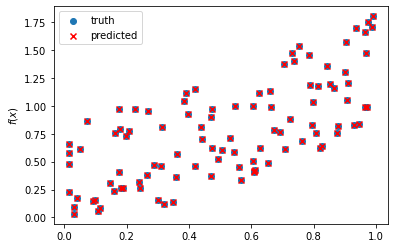

In [7]:
# predict
pred = est.predict(X)


# plotting
plt.scatter(X[:, 0], y, label = 'truth')
plt.scatter(X[:, 0], pred, marker = 'x', color = 'red', label = 'predicted')
plt.legend()
plt.ylabel(f'$f(x)$')
plt.show()

## Multidimensional Regression

In the case of $y\in\mathbb{R}^n$ being multidimensional one can either

1. treat it as $n$ seperate regression problems. This has the advantage of the search space staying small.
2. use a multidimensional loss function. This formulation can make use of shared subexpressions between the outputs.
\begin{align}
\text{argmin}_{L\in U}\cfrac{1}{Nn}\sum_{j=1}^n\sum_{i=1}^N\left(f(X_i)_j - y_{ij}\right)^2
\end{align}

In case of 1. refer to the example above or use the following example with $n=1$. In case of 2. we support two different methods:

1. **Exhaustive search**: Builds up function skeletons and then tests each assignment of operators to each skeleton.
2. **Sample search**: Randomly samples functions and evaluates them.

Both methods return their solutions in the form of computational DAGs

**Example**: 

Symbolic Regression for the function

\begin{align}
f(x) = \begin{bmatrix}
0.5x\\
-x
\end{bmatrix}
\end{align}

In [8]:
# Problem definition
X = np.random.rand(100, 1)
c = 0.5
y = np.column_stack([c*X[:,0], -X[:,0]])

### Exhaustive Search

In [9]:
# define loss function
loss_fkt = dag_search.MSE_loss_fkt(y)

# search
params = {
    'X' : X,
    'n_outps' : y.shape[1],
    'loss_fkt' : loss_fkt,
    'k' : 1,
    'n_calc_nodes' : 1,
    'n_processes' : 1,
    'topk' : 5,
    'opt_mode' : 'grid_zoom',
    'verbose' : 2,
    'max_orders' : 10000, 
    'stop_thresh' : 1e-4
}

res = dag_search.exhaustive_search(**params)

Creating evaluation orders


100%|████████████████████████████████████████████████████████████████████████████| 864/864 [00:00<00:00, 148879.61it/s]


Total orders: 305
Evaluating orders


  6%|████▏                                                               | 19/305 [00:01<00:22, 12.62it/s, best_loss=0]


Lets view the solutions found.

The result is a dictionary containing the top-k solutions that were encountered.

Each solution consists of a `graph` and its `constants`.

In [10]:
idx = 0 # solution number
graph = res['graphs'][idx]
consts = res['consts'][idx]
loss = res['losses'][idx]
print(loss)

0.0


The graph can be evaluated symbolically and will return a list of symbolic expressions (one for each output dimension):

In [11]:
exprs = graph.evaluate_symbolic(c = consts)
for expr in exprs:
    print(expr)

0.5*x_0
-x_0


Or it can be evaluated numerically for prediction:

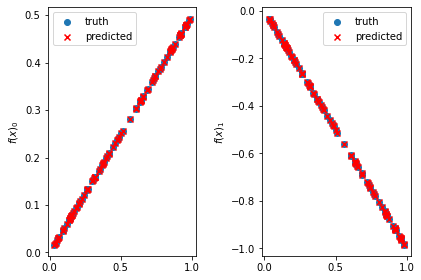

In [12]:
# predict
pred = graph.evaluate(X, c = consts)


# plotting
fig, axs = plt.subplots(ncols = y.shape[1])
for i in range(y.shape[1]):
    axs[i].scatter(X[:, 0], y[:, i], label = 'truth')
    axs[i].scatter(X[:, 0], pred[:, i], marker = 'x', color = 'red', label = 'predicted')
    axs[i].legend()
    axs[i].set_ylabel(f'$f(x)_{i}$')
plt.tight_layout()
plt.show()

### Sample Search

Lets fo trough the same pipeline for the sampling search:

In [13]:
# define loss function
loss_fkt = dag_search.MSE_loss_fkt(y)

params = {
    'X' : X,
    'n_outps' : y.shape[1],
    'loss_fkt' : loss_fkt,
    'k' : 1,
    'n_calc_nodes' : 5,
    'n_processes' : 1,
    'topk' : 5,
    'opt_mode' : 'grid_zoom',
    'verbose' : 2,
    'n_samples' : 10000,
    'stop_thresh' : 1e-4
    
}
res = dag_search.sample_search(**params)

Generating graphs


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1994.77it/s]


Evaluating graphs


 27%|████████████████▋                                             | 2691/10000 [00:01<00:03, 2129.60it/s, best_loss=0]


Select a solution:

In [14]:
idx = 0 # solution number
graph = res['graphs'][idx]
consts = res['consts'][idx]
loss = res['losses'][idx]
print(loss)

0.0


And evaluate it symbolically

In [15]:
exprs = graph.evaluate_symbolic(c = consts)
for expr in exprs:
    print(expr)

0.5*x_0
-x_0


Or numerically

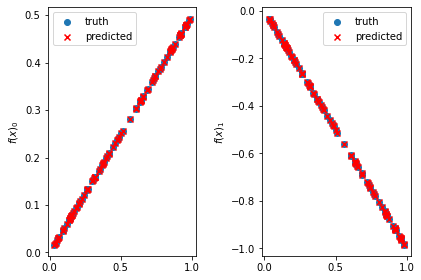

In [16]:
# predict
pred = graph.evaluate(X, c = consts)


# plotting
fig, axs = plt.subplots(ncols = y.shape[1])
for i in range(y.shape[1]):
    axs[i].scatter(X[:, 0], y[:, i], label = 'truth')
    axs[i].scatter(X[:, 0], pred[:, i], marker = 'x', color = 'red', label = 'predicted')
    axs[i].legend()
    axs[i].set_ylabel(f'$f(x)_{i}$')
plt.tight_layout()
plt.show()

## Custom Loss Function

The DAG search is not restricted to Regression tasks. In fact we can define **any loss function that depends on the function- or the gradient values**.

In [ ]:
# TODO: show how to define custom loss function